In this notebook we will train several classifiers as models to predict recidivism. We will analyze how these classifiers perform.

In [188]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline 

In [45]:
X = np.loadtxt("X.csv")
y = np.loadtxt("y.csv")
X_pandas = pd.read_csv("X_pandas.csv")

First we will partition our data into three sets: training, evaluation, and holdout. We will use the training set to build our models. We will use the evaluation set to evaluate how well our models perform. The holdout set is reserved for the end of the project; once we have tinkered with the models, we will see how well they perform on a fresh holdout set. Final conclusions should be based on analysis on the holdout set. 

In [13]:
#set random seed for reproducibility
seed = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
X_eval, X_hold, y_eval, y_hold = train_test_split(X_test, y_test, test_size=0.45)

Let's first train a logistic regression classifier.

In [36]:
logreg = LogisticRegression(C=100000, max_iter=10000)
logreg.fit(X_train,y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [42]:
print("The accuracy is {0:.4f}".format(logreg.score(X_test, y_test)))

The accuracy is 0.6914


Let's create a vector of predicted labels. Each predicted label is either 0 (if the algorithm thinks the person will not recommit a crime) or 1 (if the algorithm thinks the person will recommit a crime). We can imagine a decision-making process where people who get a predicted label = 1 are denied pre-trial release and peopple who get a predicted label = 0 are released pre-trial.

In [43]:
y_pred = logreg.predict(X_test)

We are interested in analyzing how are algorithms assigns decision based on attributes like race or gender since we want to analyze whether the algorithm is unfair.  

Create a mapping to find the column location of each variable. This is needed since NumPy doesn't maintain the column labels as strings (only as numbers). 

In [ ]:
feat_map = list(X_pandas.columns)[1:]

Create boolean vectors indicating membership in each race or gender group. 

**TODO** Finish for race_Caucasian, race_Hispanic, and race_Other.

In [95]:
males = X_test[:,feat_map.index('sex_Male')] == 1
afr_am = X_test[:,feat_map.index('race_African-American')] == 1

# Fairness Metrics
## Demographic parity

Demographic parity is a fairness concept that requires that the probability of an outcome be the same for two demographic groups. As an example, consider an algorithm determining loan approvals and consider that we are concerned about gender discrimination. The algorithm would not satisfy demographic parity if the probability of loan approval for women is 0.3 but the probability of loan approval for men is 0.8. 

Does our logistic regression classifier satisfy demographic parity with respect to race or gender? 
**TODO** Compute the means for the other race groups and gender groups. Compare the differences. How large of a difference do you think we should accept under the notion of demographic parity?

In [96]:
afr_am_mean = y_pred[afr_am].mean()
print("Logistic regression denies pre-trial release to {0:.1f}% of African-Americans".format(afr_am_mean*100))

Logistic regression denies pre-trial release to 51.6% of African-Americans


## Equalized Odds / Equal False Positive and True Positive Rates

One might argue that it is fair that women are released more often than men if in fact women are less likely to recommit a crime. Then, one could take into account the *true* label in our fairness metrics. We could compare the probability that a woman who did not recidivate would be detained to the probability that a man who did not recidivate would be detained. These quantities are known as the false positive rates.

**TODO** Compute the false positive rate for men and compare to the false positive rate for women.

In [116]:
fem_fpr = y_pred[(X_test[:,feat_map.index('sex_Female')] == 1) & (y_test==0)].mean()

We should also consider the true positive rate: the probability that a person who will recidivate would be detained. 

**TODO** Compute the false negative rates for men and women. 

**TODO** Repeat the equalized odds analysis for race. Does our logistic regression classifier satisfy equalized odds?

## Calibration

We will consider another metric that is a function of the predicted probabilities (as opposed to the predicted labels as we have considered so far). Our model is well-calibrated if the average recidivism rate for a group of people who get a predicted probability of x% is x%. We can plot a calibration curve to analyze this. The predicted probabilities range from 0 to 1, and we can split this up into ten bins: 0 to 0.1, 0.1 to 0.2, 0.2 to 0.3, and so on. On the x-axis, we plot the average of the bin (0.05, 0.15, etc) and on the y-axis we plot the average observed outcome for people who received a predicted probability in that bin.

Note the people sometimes use *score* to refer to predicted probability.


Get vector of scores

In [156]:
y_score = logreg.predict_proba(X_test)[:,1]

Assign each row to a bin

In [176]:
y_score_bins = np.where(y_score <= 0.1, 1, \
                        np.where(y_score <= 0.2, 2,\
                                 np.where(y_score <= 0.3, 3, \
                                          np.where(y_score <= 0.4, 4, \
                                                   np.where(y_score <= 0.5, 5, \
                                                            np.where(y_score <= 0.6, 6, \
                                                                    np.where(y_score <= 0.7, 7, \
                                                                              np.where(y_score <= 0.8, 8, \
                                                                                       np.where(y_score <= 0.9, 9, 10)))))))))

Compute average label outcome for each bin

In [186]:
avg_outcome = []
for b in range(1,11):
    avg = y_test[y_score_bins == b].mean()
    avg_outcome.append(avg)
    

In [137]:
avg_score = [x * 0.01 for x in range(5, 100, 10)]

Plot calibration curve: avg_score against avg_outcome. I plot a solid reference line. A better calibration model will more closely track the reference y=x line. **TODO** Why is the y=x line our reference? How well is the model calibrated? Why do you think the first point is the farthest from the reference line?

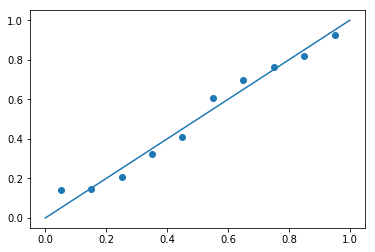

In [190]:
plt.scatter(avg_score, avg_outcome)
plt.plot([0,1], [0,1])

**TODO** Compute calibration curve for ou